## 1. Data Preparation

### R kernel:

In [13]:
# load packages
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(Matrix))
suppressPackageStartupMessages(library(parallel))
suppressPackageStartupMessages(library(iTALK))
suppressPackageStartupMessages(library(CellChat))
suppressPackageStartupMessages(library(SingleCellSignalR))
suppressPackageStartupMessages(library(CCInx))
suppressPackageStartupMessages(library(scMLnet))

# load tool functions
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_CellChat.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_iTalk.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_SingleCellSignalR.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_scMLnet.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_CCInx.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/CellPhoneDB process.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/NATMI process.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_CellPhoneDB.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_NATMI.R")

In [ ]:
# load single-cell sample data
sampleA <- readRDS("https://zenodo.org/record/6497091/files/GSE122960.rds?download=1")
sampleB <- readRDS("https://zenodo.org/record/6497091/files/GSE128033.rds?download=1")
sampleC <- readRDS("https://zenodo.org/record/6497091/files/GSE135893.rds?download=1")
sampleD <- readRDS("https://zenodo.org/record/6497091/files/GSE136831.rds?download=1")

In [4]:
# normalized data of the sample
str(sampleA@assays$RNA@data)
str(sampleB@assays$RNA@data)
str(sampleC@assays$RNA@data)
str(sampleD@assays$RNA@data)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:15028219] 33 35 45 54 55 59 61 72 86 97 ...
  ..@ p       : int [1:10414] 0 3337 5097 7069 10281 13289 15511 18031 19740 21390 ...
  ..@ Dim     : int [1:2] 33694 10413
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:33694] "RP11-34P13.3" "FAM138A" "OR4F5" "RP11-34P13.7" ...
  .. ..$ : chr [1:10413] "AAACCTGAGCACCGCT-1_2" "AAACCTGCACAGATTC-1_2" "AAACCTGGTAAGGGCT-1_2" "AAACCTGGTCAAACTC-1_2" ...
  ..@ x       : num [1:15028219] 0.686 0.401 1.09 0.401 0.686 ...
  ..@ factors : list()
Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:39789428] 47 59 86 97 153 176 189 197 216 219 ...
  ..@ p       : int [1:20628] 0 1379 2847 7202 8373 9651 13150 14990 16263 18922 ...
  ..@ Dim     : int [1:2] 45068 20627
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:45068] "RP11-34P13.3" "FAM138A" "OR4F5" "RP11-34P13.7" ...
  .. ..$ : chr [1:20627] "AAACCTGAGAGGACGG-1_2" "AAACCTGAGCGTCAAG-1_2" "AAACCTGCAGGA

In [5]:
# cell types and amounts of the sample
table(sampleA$cell.type)
table(sampleB$cell.type)
table(sampleC$cell.type)
table(sampleD$cell.type)


        AT1         AT2 Endothelial  Fibroblast  Macrophage        Mast 
        210        2293         299         147        5892         153 
   Monocyte       Tcell 
        774         645 


        AT1         AT2 Endothelial  Fibroblast  Macrophage        Mast 
       1233        1548        2553        3420        7622        1405 
   Monocyte       Tcell 
       1153        1693 


        AT1         AT2 Endothelial  Fibroblast  Macrophage        Mast 
         96        3225        3496         152       16507         360 
   Monocyte       Tcell 
       2113        2829 


        AT1         AT2 Endothelial  Fibroblast  Macrophage        Mast 
        176         496        3379        1443       60483         572 
   Monocyte       Tcell 
       6793        5088 

In [36]:
# load gold standard sample
gold <- read.table("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/data/IPF gold standard.txt", header = TRUE, sep = "\t")
str(gold)
head(gold)

'data.frame':	208 obs. of  4 variables:
 $ source  : chr  "AT1" "AT1" "AT1" "AT1" ...
 $ target  : chr  "Monocyte" "Monocyte" "Monocyte" "Macrophage" ...
 $ ligand  : chr  "TGFB1" "TGFB1" "TGFB1" "TGFB1" ...
 $ receptor: chr  "TGFBR1" "TGFBR2" "TGFBR3" "TGFBR1" ...


,source,target,ligand,receptor
,<chr>,<chr>,<chr>,<chr>
1,AT1,Monocyte,TGFB1,TGFBR1
2,AT1,Monocyte,TGFB1,TGFBR2
3,AT1,Monocyte,TGFB1,TGFBR3
4,AT1,Macrophage,TGFB1,TGFBR1
5,AT1,Macrophage,TGFB1,TGFBR2
6,AT1,Macrophage,TGFB1,TGFBR3


In [10]:
# remove unwanted genes for scMLnet
genes <- unique(c(gold$ligand, gold$receptor))
rec <- read.table("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/scMLnet_database/RecTF.txt", header = T, sep = "\t")
tf <- read.table("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/scMLnet_database/TFTargetGene.txt", header = T, sep = "\t")
rec <- rec[rec$Receptor == genes,]
tf <- tf[tf$TF == rec$TF,]
genes2 <- unique(c(genes, rec$TF, tf$Targets))
sampleA2 <- subset(sampleA, features = genes2)
sampleB2 <- subset(sampleB, features = genes2)
sampleC2 <- subset(sampleC, features = genes2)
sampleD2 <- subset(sampleD, features = genes2)

Warning message in rec$Receptor == genes:
“longer object length is not a multiple of shorter object length”
Warning message in tf$TF == rec$TF:
“longer object length is not a multiple of shorter object length”


In [11]:
# remove unwanted genes for CellChat, iTalk, SingleCellSignalR, CCInx, CellPhoneDB, and NATMI
sampleA <- subset(sampleA, features = genes) 
sampleB <- subset(sampleB, features = genes)
sampleC <- subset(sampleC, features = genes) 
sampleD <- subset(sampleD, features = genes) 

## 2. Cell-cell Interaction Prediction 

In [31]:
# CellChat
CellChatA <- run_CellChat(sampleA)
CellChatB <- run_CellChat(sampleB)
CellChatC <- run_CellChat(sampleC)
CellChatD <- run_CellChat(sampleD)

Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



The cell groups used for CellChat analysis are  Macrophage Fibroblast AT2 Monocyte Tcell AT1 Endothelial Mast 
[1] "Total predicted L-R pairs: 1"


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



The cell groups used for CellChat analysis are  Endothelial AT2 Macrophage Monocyte Fibroblast Tcell Mast AT1 
[1] "Total predicted L-R pairs: 7"


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



The cell groups used for CellChat analysis are  AT2 AT1 Endothelial Mast Monocyte Tcell Macrophage Fibroblast 
[1] "Total predicted L-R pairs: 8"


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



The cell groups used for CellChat analysis are  Macrophage Monocyte Tcell Mast Fibroblast AT2 Endothelial AT1 
[1] "Total predicted L-R pairs: 15"


In [13]:
head(CellChatA)
head(CellChatB)
head(CellChatC)
head(CellChatD)

,source,target,ligand,receptor,prob,pval
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,AT1,Fibroblast,PDGFA,PDGFRB,0.002962098,0


,source,target,ligand,receptor,prob,pval
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,Macrophage,Macrophage,TGFB1,TGFBR1,0.0014066582,0
2,Macrophage,Macrophage,TGFB1,TGFBR2,0.0014066582,0
21,Monocyte,Macrophage,TGFB1,TGFBR1,0.0008797044,0
22,Monocyte,Macrophage,TGFB1,TGFBR2,0.0008797044,0
3,Macrophage,Macrophage,CCL3,CCR1,0.0013310644,0
4,Monocyte,Macrophage,CCL3,CCR1,0.0013381925,0


,source,target,ligand,receptor,prob,pval
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,AT1,Fibroblast,PDGFA,PDGFRA,0.012570570,0
2,AT1,Fibroblast,PDGFA,PDGFRB,0.010027325,0
3,Monocyte,Macrophage,CCL3,CCR1,0.002577753,0
4,Macrophage,Macrophage,CCL3,CCR1,0.002839586,0
5,Mast,Monocyte,CSF1,CSF1R,0.005637249,0
6,Fibroblast,Monocyte,CSF1,CSF1R,0.005129437,0


,source,target,ligand,receptor,prob,pval
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,Macrophage,Fibroblast,TGFB1,TGFBR1,0.010531960,0
2,Macrophage,Fibroblast,TGFB1,TGFBR2,0.010531960,0
21,Monocyte,Fibroblast,TGFB1,TGFBR1,0.004239185,0
22,Monocyte,Fibroblast,TGFB1,TGFBR2,0.004239185,0
3,Tcell,Fibroblast,TGFB1,TGFBR1,0.015503463,0
31,Tcell,Fibroblast,TGFB1,TGFBR2,0.015503463,0


In [32]:
# iTalk
iTalkA <- run_iTalk(sampleA, top = 208)
iTalkB <- run_iTalk(sampleB, top = 208)
iTalkC <- run_iTalk(sampleC, top = 208)
iTalkD <- run_iTalk(sampleD, top = 208)

[1] "Total predicted L-R pairs: 509"
[1] "Choose top L-R pairs: 208"
[1] "Total predicted L-R pairs: 511"
[1] "Choose top L-R pairs: 208"
[1] "Total predicted L-R pairs: 566"
[1] "Choose top L-R pairs: 208"



[========>--------------------------------------------------------------]  12%

[=================>-----------------------------------------------------]  25%

[==========================>--------------------------------------------]  38%

[===================================>-----------------------------------]  50%

[===========================================>---------------------------]  62%

[====================================================>------------------]  75%

[=============================================================>---------]  88%

[=======================================================================] 100%
                                                                              



[1] "Total predicted L-R pairs: 407"
[1] "Choose top L-R pairs: 208"


In [15]:
head(iTalkA)
head(iTalkB)
head(iTalkC)
head(iTalkD)

,source,target,ligand,receptor,source_mean_exprs,target_mean_exprs
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
23,Endothelial,Fibroblast,CTGF,LRP1,1.2286853,0.8454993
22,Endothelial,Macrophage,CTGF,LRP1,1.2286853,0.5840580
2,Fibroblast,Fibroblast,CTGF,LRP1,0.8118479,0.8454993
16,AT1,Fibroblast,CTGF,LRP1,0.6911836,0.8454993
1,Fibroblast,Macrophage,CTGF,LRP1,0.8118479,0.5840580
25,Endothelial,Monocyte,CTGF,LRP1,1.2286853,0.3453390


,source,target,ligand,receptor,source_mean_exprs,target_mean_exprs
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1401,Monocyte,Endothelial,IL1B,IL1R1,1.742668,0.6223556
841,Tcell,Macrophage,CCL4,CCR1,3.764675,0.2709540
14,Fibroblast,Fibroblast,CTGF,LRP1,1.186583,0.7871848
1441,Monocyte,Fibroblast,IL1B,IL1R1,1.742668,0.4734596
851,Tcell,Monocyte,CCL4,CCR1,3.764675,0.2031794
1411,Monocyte,AT2,IL1B,IL1R1,1.742668,0.3727768


,source,target,ligand,receptor,source_mean_exprs,target_mean_exprs
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
18,Endothelial,Fibroblast,CTGF,LRP1,1.0213757,1.703772
12,AT1,Fibroblast,CTGF,LRP1,0.6978218,1.703772
24,Fibroblast,Fibroblast,CTGF,LRP1,0.6749418,1.703772
132,Monocyte,AT1,TGFB1,ITGB6,0.6380866,1.557565
236,Monocyte,AT1,TGFB1,TGFBR2,0.6380866,1.421618
136,Macrophage,AT1,TGFB1,ITGB6,0.5808058,1.557565


,source,target,ligand,receptor,source_mean_exprs,target_mean_exprs
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
134,Tcell,AT1,TGFB1,ITGB6,1.1480619,1.589999
5,Fibroblast,Fibroblast,CTGF,LRP1,1.3232609,1.176309
236,Tcell,Endothelial,TGFB1,TGFBR2,1.1480619,1.199099
237,Tcell,AT1,TGFB1,TGFBR2,1.1480619,1.164342
289,Tcell,Fibroblast,TGFB1,TGFBR3,1.1480619,1.158633
128,Macrophage,AT1,TGFB1,ITGB6,0.8076374,1.589999


In [33]:
# SingleCellSignalR
SCSRA <- run_SingleCellSignalR(sampleA)
SCSRB <- run_SingleCellSignalR(sampleB)
SCSRC <- run_SingleCellSignalR(sampleC)
SCSRD <- run_SingleCellSignalR(sampleD)

No such file as table_dge_Macrophage.txt in the cluster-analysis folder
No such file as table_dge_Fibroblast.txt in the cluster-analysis folder
No such file as table_dge_AT2.txt in the cluster-analysis folder
No such file as table_dge_Monocyte.txt in the cluster-analysis folder
No such file as table_dge_Tcell.txt in the cluster-analysis folder
No such file as table_dge_AT1.txt in the cluster-analysis folder
No such file as table_dge_Endothelial.txt in the cluster-analysis folder
No such file as table_dge_Mast.txt in the cluster-analysis folder
Paracrine signaling: 
Checking for signaling between cell types
0 No significant interaction found from Macrophage to Fibroblast
0 No significant interaction found from Macrophage to AT2
0 No significant interaction found from Macrophage to Monocyte
0 No significant interaction found from Macrophage to Tcell
0 No significant interaction found from Macrophage to AT1
0 No significant interaction found from Macrophage to Endothelial
0 No significant

No such file as table_dge_Macrophage.txt in the cluster-analysis folder
No such file as table_dge_Monocyte.txt in the cluster-analysis folder
No such file as table_dge_Tcell.txt in the cluster-analysis folder
No such file as table_dge_Mast.txt in the cluster-analysis folder
No such file as table_dge_Fibroblast.txt in the cluster-analysis folder
No such file as table_dge_AT2.txt in the cluster-analysis folder
No such file as table_dge_Endothelial.txt in the cluster-analysis folder
No such file as table_dge_AT1.txt in the cluster-analysis folder
Paracrine signaling: 
Checking for signaling between cell types
0 No significant interaction found from Macrophage to Monocyte
0 No significant interaction found from Macrophage to Tcell
0 No significant interaction found from Macrophage to Mast
0 No significant interaction found from Macrophage to Fibroblast
0 No significant interaction found from Macrophage to AT2
0 No significant interaction found from Macrophage to Endothelial
0 No significan

In [5]:
head(SCSRA)
head(SCSRB)
head(SCSRC)
head(SCSRD)

,source,target,ligand,receptor,LRscore
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Fibroblast,Monocyte,CCL2,CCR2,0.68742187149298
2,AT1,Fibroblast,PDGFA,PDGFRB,0.761042984780823
3,AT1,Fibroblast,PDGFC,PDGFRB,0.689645362246055
4,Mast,Fibroblast,TGFB1,TGFBR3,0.598945955404346
5,Mast,Monocyte,CCL2,CCR2,0.548699786843868
6,Mast,Endothelial,TGFB1,TGFBR3,0.718179341579129


,source,target,ligand,receptor,LRscore
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Endothelial,Monocyte,CCL2,CCR2,0.595674932115517
2,Mast,Macrophage,CSF1,CSF1R,0.662648748227722
3,Mast,Monocyte,CSF1,CSF1R,0.676553266700939


,source,target,ligand,receptor,LRscore
,<chr>,<chr>,<chr>,<chr>,<chr>
1,AT1,Fibroblast,PDGFA,PDGFRA,0.760414319142841
2,AT1,Fibroblast,PDGFA,PDGFRB,0.732949670274543
3,AT1,Fibroblast,PDGFC,PDGFRA,0.50380082682914
4,Mast,AT2,TGFB1,ITGB6,0.755698094707322
5,Mast,AT1,TGFB1,ITGB6,0.797994657314319
6,Monocyte,Tcell,CCL3,CCR4,0.582479392671887


,source,target,ligand,receptor,LRscore
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,NA,NA,NA,NA,NA


In [34]:
# CCInx
CCInxA <- run_CCInx(sampleA, top = 208)
CCInxB <- run_CCInx(sampleB, top = 208)
CCInxC <- run_CCInx(sampleC, top = 208)
CCInxD <- run_CCInx(sampleD, top = 208)

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 5419"
[1] "Choose top L-R pairs: 208"


-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 6287"
[1] "Choose top L-R pairs: 208"


-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 5444"
[1] "Choose top L-R pairs: 208"


-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 5950"
[1] "Choose top L-R pairs: 208"


In [7]:
head(CCInxA)
head(CCInxB)
head(CCInxC)
head(CCInxD)

,source,target,ligand,receptor,edgeWeight
,<chr>,<chr>,<chr>,<chr>,<chr>
1,AT2,Fibroblast,ITGB6,ITGB1,1
2,AT1,Fibroblast,ITGB6,ITGB1,1
3,AT1,AT2,ITGB1,ITGB6,0.987788248680122
4,AT1,AT1,ITGB1,ITGB6,0.987788248680122
5,AT1,AT1,ITGB6,ITGB1,0.987788248680122
6,AT2,Monocyte,ITGB6,ITGB1,0.987206853721975


,source,target,ligand,receptor,edgeWeight
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Endothelial,Monocyte,CCL2,IL1B,1
2,AT2,Monocyte,ITGB1,IL1B,1
3,AT2,AT2,ITGB1,ITGB6,0.995656734127857
4,AT2,AT2,ITGB6,ITGB1,0.995656734127857
5,Fibroblast,Monocyte,CCL2,IL1B,0.982470893274612
6,AT2,AT2,ITGB1,TGFBR2,0.979857454325993


,source,target,ligand,receptor,edgeWeight
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Endothelial,Mast,IL33,IL1RL1,1
2,Endothelial,Monocyte,IL33,IL1B,1
3,AT2,Endothelial,ITGB6,ITGB1,0.988816200487422
4,AT1,Endothelial,ITGB6,ITGB1,0.988816200487422
5,Endothelial,Monocyte,ITGB1,IL1B,0.988816200487422
6,AT1,Endothelial,TGFBR2,CTGF,0.97781005272738


,source,target,ligand,receptor,edgeWeight
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Mast,Monocyte,IL1RL1,IL1RAP,1
2,Endothelial,Monocyte,IL1R1,IL1RAP,1
3,Fibroblast,Tcell,CTGF,TGFB1,1
4,AT2,Tcell,ITGB6,TGFB1,1
5,AT1,Tcell,ITGB6,TGFB1,1
6,Endothelial,Tcell,TGFBR2,TGFB1,0.998704907678036


In [15]:
# scMLnet
scMLnetA <- run_scMLnet(sampleA2)

[1] "check table cell:"
[1] 10413     2
[1] "Rec Cluster:"
[1] "Fibroblast"
[1] "Lig Cluster:"
[1] "Macrophage"
[1] "p val:"
[1] 0.05
[1] "logfc:"
[1] 0.15
[1] "get High Exp Gene in Fibroblast"
[1] "Fibroblast:147"
[1] "gene:121"
[1] "logfc.threshold:"
[1] 0.15
[1] "do T-test"
[1] "find high gene num:35"
[1] "-----------------------"
[1] "get High Exp Gene in Macrophage"
[1] "Macrophage:5892"
[1] "gene:121"
[1] "logfc.threshold:"
[1] 0.15
[1] "do T-test"
[1] "find high gene num:21"
[1] "-----------------------"
[1] "Lig_Rec Num:6"
[1] "TF_Target Num:0"
[1] "XZRec_XZTF Num:1485"
[1] "Rec common in LigRec and RecTF:"
[1] "TF common in RecTF and TFTar:"
Error in RunMLnet(mtx, annfile, RecClu, LigClu, pval, logfc, LigRecLib,  : 
  error:RecTF and TFTar don't have the same TF!
[1] "check table cell:"
[1] 10413     2
[1] "Rec Cluster:"
[1] "AT2"
[1] "Lig Cluster:"
[1] "Macrophage"
[1] "p val:"
[1] 0.05
[1] "logfc:"
[1] 0.15
[1] "get High Exp Gene in AT2"
[1] "AT2:2293"
[1] "gene:121"
[1] "lo

In [16]:
scMLnetB <- run_scMLnet(sampleB2)

[1] "check table cell:"
[1] 20627     2
[1] "Rec Cluster:"
[1] "AT2"
[1] "Lig Cluster:"
[1] "Endothelial"
[1] "p val:"
[1] 0.05
[1] "logfc:"
[1] 0.15
[1] "get High Exp Gene in AT2"
[1] "AT2:1548"
[1] "gene:121"
[1] "logfc.threshold:"
[1] 0.15
[1] "do T-test"
[1] "find high gene num:43"
[1] "-----------------------"
[1] "get High Exp Gene in Endothelial"
[1] "Endothelial:2553"
[1] "gene:121"
[1] "logfc.threshold:"
[1] 0.15
[1] "do T-test"
[1] "find high gene num:18"
[1] "-----------------------"
[1] "Lig_Rec Num:0"
[1] "TF_Target Num:2"
[1] "XZRec_XZTF Num:3795"
Error in seq.default(1, length(PairList), 1) : 
  wrong sign in 'by' argument
[1] "check table cell:"
[1] 20627     2
[1] "Rec Cluster:"
[1] "Macrophage"
[1] "Lig Cluster:"
[1] "Endothelial"
[1] "p val:"
[1] 0.05
[1] "logfc:"
[1] 0.15
[1] "get High Exp Gene in Macrophage"
[1] "Macrophage:7622"
[1] "gene:121"
[1] "logfc.threshold:"
[1] 0.15
[1] "do T-test"
[1] "find high gene num:38"
[1] "-----------------------"
[1] "get High Ex

Warning message in if (!netList[[i]] %in% NA) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!netList[[i]] %in% NA) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!netList[[i]] %in% NA) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!netList[[i]] %in% NA) {:
“the condition has length > 1 and only the first element will be used”


[1] "Total predicted L-R pairs: 9"


In [17]:
scMLnetC <- run_scMLnet(sampleC2)

[1] "check table cell:"
[1] 28778     2
[1] "Rec Cluster:"
[1] "AT1"
[1] "Lig Cluster:"
[1] "AT2"
[1] "p val:"
[1] 0.05
[1] "logfc:"
[1] 0.15
[1] "get High Exp Gene in AT1"
[1] "AT1:96"
[1] "gene:121"
[1] "logfc.threshold:"
[1] 0.15
[1] "do T-test"
[1] "find high gene num:10"
[1] "-----------------------"
[1] "get High Exp Gene in AT2"
[1] "AT2:3225"
[1] "gene:121"
[1] "logfc.threshold:"
[1] 0.15
[1] "do T-test"
[1] "find high gene num:12"
[1] "-----------------------"
[1] "Lig_Rec Num:3"
[1] "TF_Target Num:0"
Error in seq.default(1, length(XZRec), 1) : wrong sign in 'by' argument
[1] "check table cell:"
[1] 28778     2
[1] "Rec Cluster:"
[1] "Endothelial"
[1] "Lig Cluster:"
[1] "AT2"
[1] "p val:"
[1] 0.05
[1] "logfc:"
[1] 0.15
[1] "get High Exp Gene in Endothelial"
[1] "Endothelial:3496"
[1] "gene:121"
[1] "logfc.threshold:"
[1] 0.15
[1] "do T-test"
[1] "find high gene num:34"
[1] "-----------------------"
[1] "get High Exp Gene in AT2"
[1] "AT2:3225"
[1] "gene:121"
[1] "logfc.thresho

In [18]:
scMLnetD <- run_scMLnet(sampleD2)

[1] "check table cell:"
[1] 78430     2
[1] "Rec Cluster:"
[1] "Monocyte"
[1] "Lig Cluster:"
[1] "Macrophage"
[1] "p val:"
[1] 0.05
[1] "logfc:"
[1] 0.15
[1] "get High Exp Gene in Monocyte"
[1] "Monocyte:6793"
[1] "gene:119"
[1] "logfc.threshold:"
[1] 0.15
[1] "do T-test"
[1] "find high gene num:6"
[1] "-----------------------"
[1] "get High Exp Gene in Macrophage"
[1] "Macrophage:60483"
[1] "gene:119"
[1] "logfc.threshold:"
[1] 0.15
[1] "do T-test"
[1] "find high gene num:56"
[1] "-----------------------"
[1] "Lig_Rec Num:2"
[1] "TF_Target Num:0"
Error in seq.default(1, length(XZRec), 1) : wrong sign in 'by' argument
[1] "check table cell:"
[1] 78430     2
[1] "Rec Cluster:"
[1] "Tcell"
[1] "Lig Cluster:"
[1] "Macrophage"
[1] "p val:"
[1] 0.05
[1] "logfc:"
[1] 0.15
[1] "get High Exp Gene in Tcell"
[1] "Tcell:5088"
[1] "gene:119"
[1] "logfc.threshold:"
[1] 0.15
[1] "do T-test"
[1] "find high gene num:8"
[1] "-----------------------"
[1] "get High Exp Gene in Macrophage"
[1] "Macrophage

Warning message in if (!netList[[i]] %in% NA) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!netList[[i]] %in% NA) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!netList[[i]] %in% NA) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!netList[[i]] %in% NA) {:
“the condition has length > 1 and only the first element will be used”


[1] "Total predicted L-R pairs: 8"


In [19]:
head(scMLnetA)
head(scMLnetB)
head(scMLnetC)
head(scMLnetD)

,source,target,ligrec
,<lgl>,<lgl>,<lgl>
1,NA,NA,NA


,source,target,ligrec
,<chr>,<chr>,<chr>
1,Monocyte,AT2,IL1A_IL1R1
2,Monocyte,AT2,IL1B_IL1R1
3,Monocyte,Fibroblast,IL1A_IL1R1
4,Monocyte,Fibroblast,IL1B_IL1R1
5,Mast,Macrophage,CCL4_CCR5
6,Mast,Macrophage,CCL4_CCR1


,source,target,ligrec
,<lgl>,<lgl>,<lgl>
1,NA,NA,NA


,source,target,ligrec
,<chr>,<chr>,<chr>
1,Monocyte,Fibroblast,IL1B_IL1R1
2,Monocyte,Endothelial,IL1B_IL1R1
3,Tcell,Fibroblast,TGFB1_ITGAV
4,Tcell,Fibroblast,TGFB1_TGFBR1
5,Tcell,Fibroblast,TGFB1_ITGB6
6,Tcell,Fibroblast,TGFB1_TGFBR3


In [6]:
# CellPhoneDB
CellPhoneDB_process(sampleA)
CellPhoneDB_process(sampleB)
CellPhoneDB_process(sampleC)
CellPhoneDB_process(sampleD)

### Python kernel:

In [1]:
!ls -AR cpdb

cpdb:
sampleA  sampleB  sampleC  sampleD

cpdb/sampleA:
barcodes.tsv  features.tsv  matrix.mtx	meta.tsv

cpdb/sampleB:
barcodes.tsv  features.tsv  matrix.mtx	meta.tsv

cpdb/sampleC:
barcodes.tsv  features.tsv  matrix.mtx	meta.tsv

cpdb/sampleD:
barcodes.tsv  features.tsv  matrix.mtx	meta.tsv


In [2]:
!source activate cpdb

In [2]:
!cellphonedb method statistical_analysis cpdb/sampleA/meta.tsv cpdb/sampleA/ --counts-data hgnc_symbol --output-path cpdb/sampleA/out

[ ][APP][25/04/22-16:52:37][WARNING] Latest local available version is `v2.0.0`, using it
[ ][APP][25/04/22-16:52:37][WARNING] User selected downloaded database `v2.0.0` is available, using it
[ ][CORE][25/04/22-16:52:37][INFO] Initializing SqlAlchemy CellPhoneDB Core
[ ][CORE][25/04/22-16:52:37][INFO] Using custom database at /home/bioinformatics/.cpdb/releases/v2.0.0/cellphone.db
[ ][APP][25/04/22-16:52:37][INFO] Launching Method cpdb_statistical_analysis_local_method_launcher
[ ][APP][25/04/22-16:52:37][INFO] Launching Method _set_paths
[ ][APP][25/04/22-16:52:37][INFO] Launching Method _load_meta_counts
[ ][APP][25/04/22-16:52:37][INFO] Launching Method _check_counts_data
[ ][CORE][25/04/22-16:52:37][INFO] Launching Method cpdb_statistical_analysis_launcher
[ ][CORE][25/04/22-16:52:37][INFO] Launching Method _counts_validations
[ ][CORE][25/04/22-16:52:37][INFO] Launching Method get_interactions_genes_complex
[ ][CORE][25/04/22-16:52:38][INFO] [Cluster Statistical Analysis] Thresho

In [3]:
!cellphonedb method statistical_analysis cpdb/sampleB/meta.tsv cpdb/sampleB/ --counts-data hgnc_symbol --output-path cpdb/sampleB/out

[ ][APP][25/04/22-17:34:45][WARNING] Latest local available version is `v2.0.0`, using it
[ ][APP][25/04/22-17:34:45][WARNING] User selected downloaded database `v2.0.0` is available, using it
[ ][CORE][25/04/22-17:34:45][INFO] Initializing SqlAlchemy CellPhoneDB Core
[ ][CORE][25/04/22-17:34:45][INFO] Using custom database at /home/bioinformatics/.cpdb/releases/v2.0.0/cellphone.db
[ ][APP][25/04/22-17:34:45][INFO] Launching Method cpdb_statistical_analysis_local_method_launcher
[ ][APP][25/04/22-17:34:45][INFO] Launching Method _set_paths
[ ][APP][25/04/22-17:34:45][INFO] Launching Method _load_meta_counts
[ ][APP][25/04/22-17:34:45][INFO] Launching Method _check_counts_data
[ ][CORE][25/04/22-17:34:45][INFO] Launching Method cpdb_statistical_analysis_launcher
[ ][CORE][25/04/22-17:34:45][INFO] Launching Method _counts_validations
[ ][CORE][25/04/22-17:34:45][INFO] Launching Method get_interactions_genes_complex
[ ][CORE][25/04/22-17:34:46][INFO] [Cluster Statistical Analysis] Thresho

In [4]:
!cellphonedb method statistical_analysis cpdb/sampleC/meta.tsv cpdb/sampleC/ --counts-data hgnc_symbol --output-path cpdb/sampleC/out

[ ][APP][25/04/22-18:55:33][WARNING] Latest local available version is `v2.0.0`, using it
[ ][APP][25/04/22-18:55:33][WARNING] User selected downloaded database `v2.0.0` is available, using it
[ ][CORE][25/04/22-18:55:33][INFO] Initializing SqlAlchemy CellPhoneDB Core
[ ][CORE][25/04/22-18:55:33][INFO] Using custom database at /home/bioinformatics/.cpdb/releases/v2.0.0/cellphone.db
[ ][APP][25/04/22-18:55:33][INFO] Launching Method cpdb_statistical_analysis_local_method_launcher
[ ][APP][25/04/22-18:55:33][INFO] Launching Method _set_paths
[ ][APP][25/04/22-18:55:33][INFO] Launching Method _load_meta_counts
[ ][APP][25/04/22-18:55:33][INFO] Launching Method _check_counts_data
[ ][CORE][25/04/22-18:55:33][INFO] Launching Method cpdb_statistical_analysis_launcher
[ ][CORE][25/04/22-18:55:33][INFO] Launching Method _counts_validations
[ ][CORE][25/04/22-18:55:34][INFO] Launching Method get_interactions_genes_complex
[ ][CORE][25/04/22-18:55:34][INFO] [Cluster Statistical Analysis] Thresho

In [5]:
!cellphonedb method statistical_analysis cpdb/sampleD/meta.tsv cpdb/sampleD/ --counts-data hgnc_symbol --output-path cpdb/sampleD/out

[ ][APP][25/04/22-20:48:22][WARNING] Latest local available version is `v2.0.0`, using it
[ ][APP][25/04/22-20:48:22][WARNING] User selected downloaded database `v2.0.0` is available, using it
[ ][CORE][25/04/22-20:48:22][INFO] Initializing SqlAlchemy CellPhoneDB Core
[ ][CORE][25/04/22-20:48:22][INFO] Using custom database at /home/bioinformatics/.cpdb/releases/v2.0.0/cellphone.db
[ ][APP][25/04/22-20:48:22][INFO] Launching Method cpdb_statistical_analysis_local_method_launcher
[ ][APP][25/04/22-20:48:22][INFO] Launching Method _set_paths
[ ][APP][25/04/22-20:48:22][INFO] Launching Method _load_meta_counts
[ ][APP][25/04/22-20:48:23][INFO] Launching Method _check_counts_data
[ ][CORE][25/04/22-20:48:23][INFO] Launching Method cpdb_statistical_analysis_launcher
[ ][CORE][25/04/22-20:48:23][INFO] Launching Method _counts_validations
[ ][CORE][25/04/22-20:48:23][INFO] Launching Method get_interactions_genes_complex
[ ][CORE][25/04/22-20:48:23][INFO] [Cluster Statistical Analysis] Thresho

### R kernel:

In [20]:
CellPhoneDBA <- run_CellPhoneDB_output("sampleA")
head(CellPhoneDBA)

,cellA,cellB,geneA,geneB
,<chr>,<chr>,<chr>,<chr>
1,AT1,Endothelial,TGFB1,TGFBR3
2,AT1,Fibroblast,PDGFA,PDGFRA
3,Endothelial,Endothelial,TGFB1,TGFBR3
4,Endothelial,Fibroblast,PDGFB,PDGFRA
5,Endothelial,Fibroblast,PDGFB,PDGFRB
6,Endothelial,Fibroblast,PDGFB,LRP1


In [21]:
CellPhoneDBB <- run_CellPhoneDB_output("sampleB")
head(CellPhoneDBB)

,cellA,cellB,geneA,geneB
,<chr>,<chr>,<chr>,<chr>
1,AT2,Endothelial,TGFB1,TGFBR3
2,AT2,Fibroblast,PDGFA,PDGFRA
3,Endothelial,Endothelial,TGFB1,TGFBR3
4,Fibroblast,AT2,IGF1,IGF1R
5,Fibroblast,AT2,PDGFRA,PDGFC
6,Fibroblast,Endothelial,TGFB1,TGFBR3


In [22]:
CellPhoneDBC <- run_CellPhoneDB_output("sampleC")
head(CellPhoneDBC)

,cellA,cellB,geneA,geneB
,<chr>,<chr>,<chr>,<chr>
1,AT1,Fibroblast,PDGFA,PDGFRA
2,AT2,Endothelial,TGFB1,TGFBR3
3,Endothelial,Endothelial,TGFB1,TGFBR3
4,Endothelial,Fibroblast,PDGFB,PDGFRA
5,Endothelial,Fibroblast,PDGFB,PDGFRB
6,Endothelial,Fibroblast,PDGFB,LRP1


In [23]:
CellPhoneDBD <- run_CellPhoneDB_output("sampleD")
head(CellPhoneDBD)

,cellA,cellB,geneA,geneB
,<chr>,<chr>,<chr>,<chr>
1,AT1,Endothelial,TGFB1,TGFBR3
2,AT1,Fibroblast,TGFB1,TGFBR3
3,AT2,Endothelial,TGFB1,TGFBR3
4,AT2,Fibroblast,TGFB1,TGFBR3
5,Endothelial,Endothelial,TGFB1,TGFBR3
6,Endothelial,Fibroblast,PDGFB,PDGFRB


In [16]:
# NATMI
NATMI_process(sampleA)
NATMI_process(sampleB)
NATMI_process(sampleC)
NATMI_process(sampleD)

### Python kernel:

In [1]:
!ls -AR natmi

natmi:
sampleA  sampleB  sampleC  sampleD

natmi/sampleA:
ann.csv  em.csv

natmi/sampleB:
ann.csv  em.csv

natmi/sampleC:
ann.csv  em.csv

natmi/sampleD:
ann.csv  em.csv


In [2]:
!docker run --rm -it --name natmi -v /home/bioinformatics/Documents/Benchmark/Python/natmi/sampleA/:/opt/NATMI/workdir asrhou/natmi python ExtractEdges.py --emFile /opt/NATMI/workdir/em.csv --annFile /opt/NATMI/workdir/ann.csv --interDB lrc2p --out /opt/NATMI/workdir/out

Input data:
Species to obtain abundance data: human
The expression matrix file: /opt/NATMI/workdir/em.csv
The metafile: /opt/NATMI/workdir/ann.csv
The ligand-receptor interaction database: lrc2p.csv
Species to obtain ligand-receptor interactions: human
The number of cores to use: 1
The folder to save all results: /opt/NATMI/workdir/out
#### the folder "/opt/NATMI/workdir/out" has been created to save the analysis results
#### cluster the expression matrix
#### generate cell-to-cell interactions
#### extract signaling factors
#### construct signaling interactions
#### collected 1512 LR-mediated edges
#### DONE


In [3]:
!docker run --rm -it --name natmi -v /home/bioinformatics/Documents/Benchmark/Python/natmi/sampleA/:/opt/NATMI/workdir asrhou/natmi python VisInteractions.py --sourceFolder /opt/NATMI/workdir/out --interDB lrc2p --weightType mean --detectionThreshold 0.2

Input data:
The source dataset folder: /opt/NATMI/workdir/out
The ligand-receptor interaction database: lrc2p
The weight type of cell-to-cell signaling: mean
The detection threshold for interactions to draw is: 0.2
The specicificity threshold for interactions to draw is: 0
The expression threshold for interactions to draw is: 0
The network layout: kk
The font size for cluster labels: 8
The edge width: 0
The maximum radius of the clusters: 0
The relative distance between clusters: 1
The plot width: 12
The plot height: 10
The plot format: pdf
#### start to construct the cell-to-cell communication network
#### 51 edges are loaded
#### plotting the weighted directed cell-to-cell communication network
#### the folder "/opt/NATMI/workdir/out/Network_exp_0_spe_0_det_0.2_top_0_signal_lrc2p_weight_mean" has been created to save the analysis results
#### DONE


In [4]:
!docker run --rm -it --name natmi -v /home/bioinformatics/Documents/Benchmark/Python/natmi/sampleB/:/opt/NATMI/workdir asrhou/natmi python ExtractEdges.py --emFile /opt/NATMI/workdir/em.csv --annFile /opt/NATMI/workdir/ann.csv --interDB lrc2p --out /opt/NATMI/workdir/out

Input data:
Species to obtain abundance data: human
The expression matrix file: /opt/NATMI/workdir/em.csv
The metafile: /opt/NATMI/workdir/ann.csv
The ligand-receptor interaction database: lrc2p.csv
Species to obtain ligand-receptor interactions: human
The number of cores to use: 1
The folder to save all results: /opt/NATMI/workdir/out
#### the folder "/opt/NATMI/workdir/out" has been created to save the analysis results
#### cluster the expression matrix
#### generate cell-to-cell interactions
#### extract signaling factors
#### construct signaling interactions
#### collected 1856 LR-mediated edges
#### DONE


In [7]:
!docker run --rm -it --name natmi -v /home/bioinformatics/Documents/Benchmark/Python/natmi/sampleB/:/opt/NATMI/workdir asrhou/natmi python VisInteractions.py --sourceFolder /opt/NATMI/workdir/out --interDB lrc2p --weightType mean --detectionThreshold 0.2

Input data:
The source dataset folder: /opt/NATMI/workdir/out
The ligand-receptor interaction database: lrc2p
The weight type of cell-to-cell signaling: mean
The detection threshold for interactions to draw is: 0.2
The specicificity threshold for interactions to draw is: 0
The expression threshold for interactions to draw is: 0
The network layout: kk
The font size for cluster labels: 8
The edge width: 0
The maximum radius of the clusters: 0
The relative distance between clusters: 1
The plot width: 12
The plot height: 10
The plot format: pdf
#### start to construct the cell-to-cell communication network
#### 85 edges are loaded
#### plotting the weighted directed cell-to-cell communication network
#### the folder "/opt/NATMI/workdir/out/Network_exp_0_spe_0_det_0.2_top_0_signal_lrc2p_weight_mean" has been created to save the analysis results
#### DONE


In [5]:
!docker run --rm -it --name natmi -v /home/bioinformatics/Documents/Benchmark/Python/natmi/sampleC/:/opt/NATMI/workdir asrhou/natmi python ExtractEdges.py --emFile /opt/NATMI/workdir/em.csv --annFile /opt/NATMI/workdir/ann.csv --interDB lrc2p --out /opt/NATMI/workdir/out

Input data:
Species to obtain abundance data: human
The expression matrix file: /opt/NATMI/workdir/em.csv
The metafile: /opt/NATMI/workdir/ann.csv
The ligand-receptor interaction database: lrc2p.csv
Species to obtain ligand-receptor interactions: human
The number of cores to use: 1
The folder to save all results: /opt/NATMI/workdir/out
#### the folder "/opt/NATMI/workdir/out" has been created to save the analysis results
#### cluster the expression matrix
#### generate cell-to-cell interactions
#### extract signaling factors
#### construct signaling interactions
#### collected 1521 LR-mediated edges
#### DONE


In [8]:
!docker run --rm -it --name natmi -v /home/bioinformatics/Documents/Benchmark/Python/natmi/sampleC/:/opt/NATMI/workdir asrhou/natmi python VisInteractions.py --sourceFolder /opt/NATMI/workdir/out --interDB lrc2p --weightType mean --detectionThreshold 0.2

Input data:
The source dataset folder: /opt/NATMI/workdir/out
The ligand-receptor interaction database: lrc2p
The weight type of cell-to-cell signaling: mean
The detection threshold for interactions to draw is: 0.2
The specicificity threshold for interactions to draw is: 0
The expression threshold for interactions to draw is: 0
The network layout: kk
The font size for cluster labels: 8
The edge width: 0
The maximum radius of the clusters: 0
The relative distance between clusters: 1
The plot width: 12
The plot height: 10
The plot format: pdf
#### start to construct the cell-to-cell communication network
#### 132 edges are loaded
#### plotting the weighted directed cell-to-cell communication network
#### the folder "/opt/NATMI/workdir/out/Network_exp_0_spe_0_det_0.2_top_0_signal_lrc2p_weight_mean" has been created to save the analysis results
#### DONE


In [6]:
!docker run --rm -it --name natmi -v /home/bioinformatics/Documents/Benchmark/Python/natmi/sampleD/:/opt/NATMI/workdir asrhou/natmi python ExtractEdges.py --emFile /opt/NATMI/workdir/em.csv --annFile /opt/NATMI/workdir/ann.csv --interDB lrc2p --out /opt/NATMI/workdir/out

Input data:
Species to obtain abundance data: human
The expression matrix file: /opt/NATMI/workdir/em.csv
The metafile: /opt/NATMI/workdir/ann.csv
The ligand-receptor interaction database: lrc2p.csv
Species to obtain ligand-receptor interactions: human
The number of cores to use: 1
The folder to save all results: /opt/NATMI/workdir/out
#### the folder "/opt/NATMI/workdir/out" has been created to save the analysis results
#### cluster the expression matrix
#### generate cell-to-cell interactions
#### extract signaling factors
#### construct signaling interactions
#### collected 1674 LR-mediated edges
#### DONE


In [9]:
!docker run --rm -it --name natmi -v /home/bioinformatics/Documents/Benchmark/Python/natmi/sampleD/:/opt/NATMI/workdir asrhou/natmi python VisInteractions.py --sourceFolder /opt/NATMI/workdir/out --interDB lrc2p --weightType mean --detectionThreshold 0.2

Input data:
The source dataset folder: /opt/NATMI/workdir/out
The ligand-receptor interaction database: lrc2p
The weight type of cell-to-cell signaling: mean
The detection threshold for interactions to draw is: 0.2
The specicificity threshold for interactions to draw is: 0
The expression threshold for interactions to draw is: 0
The network layout: kk
The font size for cluster labels: 8
The edge width: 0
The maximum radius of the clusters: 0
The relative distance between clusters: 1
The plot width: 12
The plot height: 10
The plot format: pdf
#### start to construct the cell-to-cell communication network
#### 172 edges are loaded
#### plotting the weighted directed cell-to-cell communication network
#### the folder "/opt/NATMI/workdir/out/Network_exp_0_spe_0_det_0.2_top_0_signal_lrc2p_weight_mean" has been created to save the analysis results
#### DONE


### R kernel:

In [24]:
NATMIA <- run_NATMI_output("sampleA")
head(NATMIA)

,source,target,ligand,receptor
,<chr>,<chr>,<chr>,<chr>
1,AT1,Macrophage,CCL2,CCR1
2,AT1,Monocyte,CCL2,CCR1
3,Fibroblast,Macrophage,CCL2,CCR1
4,Fibroblast,Monocyte,CCL2,CCR1
5,Macrophage,Macrophage,CCL2,CCR1
6,Macrophage,Monocyte,CCL2,CCR1


In [25]:
NATMIB <- run_NATMI_output("sampleB")
head(NATMIB)

,source,target,ligand,receptor
,<chr>,<chr>,<chr>,<chr>
1,Endothelial,Macrophage,CCL2,CCR1
2,Fibroblast,Macrophage,CCL2,CCR1
3,Macrophage,Macrophage,CCL2,CCR1
4,Monocyte,Macrophage,CCL2,CCR1
5,Macrophage,Macrophage,CCL3,CCR1
6,Monocyte,Macrophage,CCL3,CCR1


In [26]:
NATMIC <- run_NATMI_output("sampleC")
head(NATMIC)

,source,target,ligand,receptor
,<chr>,<chr>,<chr>,<chr>
1,Endothelial,Macrophage,CCL2,CCR1
2,Endothelial,Monocyte,CCL2,CCR1
3,Fibroblast,Macrophage,CCL2,CCR1
4,Fibroblast,Monocyte,CCL2,CCR1
5,Macrophage,Macrophage,CCL2,CCR1
6,Macrophage,Monocyte,CCL2,CCR1


In [27]:
NATMID <- run_NATMI_output("sampleD")
head(NATMID)

,source,target,ligand,receptor
,<chr>,<chr>,<chr>,<chr>
1,AT1,Macrophage,CCL2,CCR1
2,Endothelial,Macrophage,CCL2,CCR1
3,Fibroblast,Macrophage,CCL2,CCR1
4,Macrophage,Macrophage,CCL2,CCR1
5,Tcell,Macrophage,CCL4,CCR1
6,Fibroblast,Macrophage,CSF1,CSF1R


## 3. SSP Calculation

In [29]:
# load functions
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/CellChat_SSP_calculation.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/iTalk_SSP_calculation.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/SingleCellSignalR_SSP_calculation.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/CCInx_SSP_calculation.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/scMLnet_SSP_calculation.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/CellPhoneDB_SSP_calculation.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/NATMI_SSP_calculation.R")

In [37]:
CellChat_SSPA <- run_CellChat_SSP(CellChatA,sampleA,gold)
iTalk_SSPA <- run_iTalk_SSP(iTalkA,sampleA,gold)
SingleCellSignalR_SSPA <- run_SingleCellSignalR_SSP(SCSRA,sampleA,gold)
CCInx_SSPA <- run_CCInx_SSP(CCInxA,sampleA,gold)
scMLnet_SSPA <- run_scMLnet_SSP(scMLnetA,sampleA,gold)
CellPhoneDB_SSPA <- run_CellPhoneDB_SSP(CellPhoneDBA,sampleA,gold)
NATMI_SSPA <- run_NATMI_SSP(NATMIA,sampleA,gold)

In [38]:
CellChat_SSPB <- run_CellChat_SSP(CellChatB,sampleB,gold)
iTalk_SSPB <- run_iTalk_SSP(iTalkB,sampleB,gold)
SingleCellSignalR_SSPB <- run_SingleCellSignalR_SSP(SCSRB,sampleB,gold)
CCInx_SSPB <- run_CCInx_SSP(CCInxB,sampleB,gold)
scMLnet_SSPB <- run_scMLnet_SSP(scMLnetB,sampleB,gold)
CellPhoneDB_SSPB <- run_CellPhoneDB_SSP(CellPhoneDBB,sampleB,gold)
NATMI_SSPB <- run_NATMI_SSP(NATMIB,sampleB,gold)

In [39]:
CellChat_SSPC <- run_CellChat_SSP(CellChatC,sampleC,gold)
iTalk_SSPC <- run_iTalk_SSP(iTalkC,sampleC,gold)
SingleCellSignalR_SSPC <- run_SingleCellSignalR_SSP(SCSRC,sampleC,gold)
CCInx_SSPC <- run_CCInx_SSP(CCInxC,sampleC,gold)
scMLnet_SSPC <- run_scMLnet_SSP(scMLnetC,sampleC,gold)
CellPhoneDB_SSPC <- run_CellPhoneDB_SSP(CellPhoneDBC,sampleC,gold)
NATMI_SSPC <- run_NATMI_SSP(NATMIC,sampleC,gold)

In [40]:
CellChat_SSPD <- run_CellChat_SSP(CellChatD,sampleD,gold)
iTalk_SSPD <- run_iTalk_SSP(iTalkD,sampleD,gold)
SingleCellSignalR_SSPD <- run_SingleCellSignalR_SSP(SCSRD,sampleD,gold)
CCInx_SSPD <- run_CCInx_SSP(CCInxD,sampleD,gold)
scMLnet_SSPD <- run_scMLnet_SSP(scMLnetD,sampleD,gold)
CellPhoneDB_SSPD <- run_CellPhoneDB_SSP(CellPhoneDBD,sampleD,gold)
NATMI_SSPD <- run_NATMI_SSP(NATMID,sampleD,gold)

In [41]:
cbind(CellChat_SSPA,CellChat_SSPB,CellChat_SSPC,CellChat_SSPD)
cbind(iTalk_SSPA,iTalk_SSPB,iTalk_SSPC,iTalk_SSPD)
cbind(SingleCellSignalR_SSPA,SingleCellSignalR_SSPB,SingleCellSignalR_SSPC,SingleCellSignalR_SSPD)
cbind(CCInx_SSPA,CCInx_SSPB,CCInx_SSPC,CCInx_SSPD)
cbind(scMLnet_SSPA,scMLnet_SSPB,scMLnet_SSPC,scMLnet_SSPD)
cbind(CellPhoneDB_SSPA,CellPhoneDB_SSPB,CellPhoneDB_SSPC,CellPhoneDB_SSPD)
cbind(NATMI_SSPA,NATMI_SSPB,NATMI_SSPC,NATMI_SSPD)

CellChat_SSPA CellChat_SSPB CellChat_SSPC CellChat_SSPD
Accuracy    1             0.2857143     0.5           0.6          
Sensitivity 0.004166667   0.008438819   0.01666667    0.03846154   
Specificity 1             0.9974962     0.998         0.996991

iTalk_SSPA iTalk_SSPB iTalk_SSPC iTalk_SSPD
Accuracy    0.3365385  0.2788462  0.2644231  0.375     
Sensitivity 0.3465347  0.2815534  0.2696078  0.3786408 
Specificity 0.9493392  0.9446903  0.943459   0.9525027

SingleCellSignalR_SSPA SingleCellSignalR_SSPB
Accuracy    0.8333333              0.3333333             
Sensitivity 0.02525253             0.005050505           
Specificity 0.9995524              0.9991047             
            SingleCellSignalR_SSPC SingleCellSignalR_SSPD
Accuracy    0.5833333              0                     
Sensitivity 0.03535354             0                     
Specificity 0.9977619              0.9995526

CCInx_SSPA CCInx_SSPB CCInx_SSPC CCInx_SSPD
Accuracy    0.01923077 0.04807692 0.02403846 0.01442308
Sensitivity 0.02116402 0.05235602 0.02645503 0.01587302
Specificity 0.9407321  0.9425921  0.9411253  0.9406485

scMLnet_SSPA scMLnet_SSPB scMLnet_SSPC scMLnet_SSPD
Accuracy    0            0.1111111    0            0.5         
Sensitivity 0            0.005291005  0            0.02116402  
Specificity 0.9995413    0.9963336    0.9995413    0.9981643

CellPhoneDB_SSPA CellPhoneDB_SSPB CellPhoneDB_SSPC CellPhoneDB_SSPD
Accuracy    0.3793103        0.2291667        0.25             0.4177215       
Sensitivity 0.1195652        0.05978261       0.06989247       0.1823204       
Specificity 0.9829868        0.9824894        0.981569         0.9781991

NATMI_SSPA NATMI_SSPB NATMI_SSPC NATMI_SSPD
Accuracy    0.3333333  0.2705882  0.280303   0.3895349 
Sensitivity 0.0923913  0.125      0.201087   0.3641304 
Specificity 0.983463   0.9698444  0.9537938  0.94893

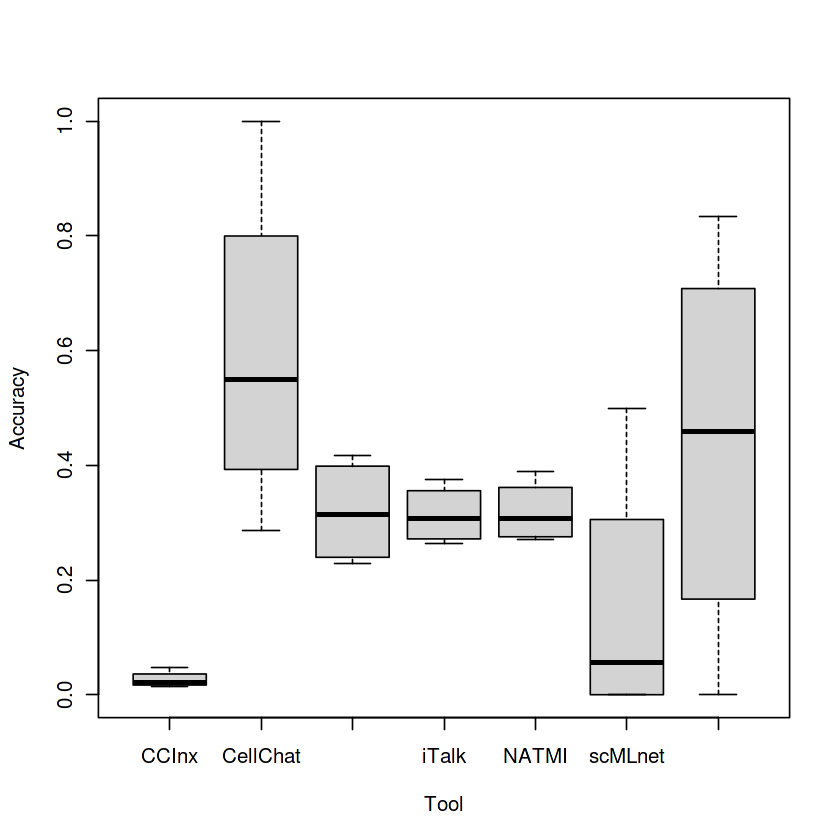

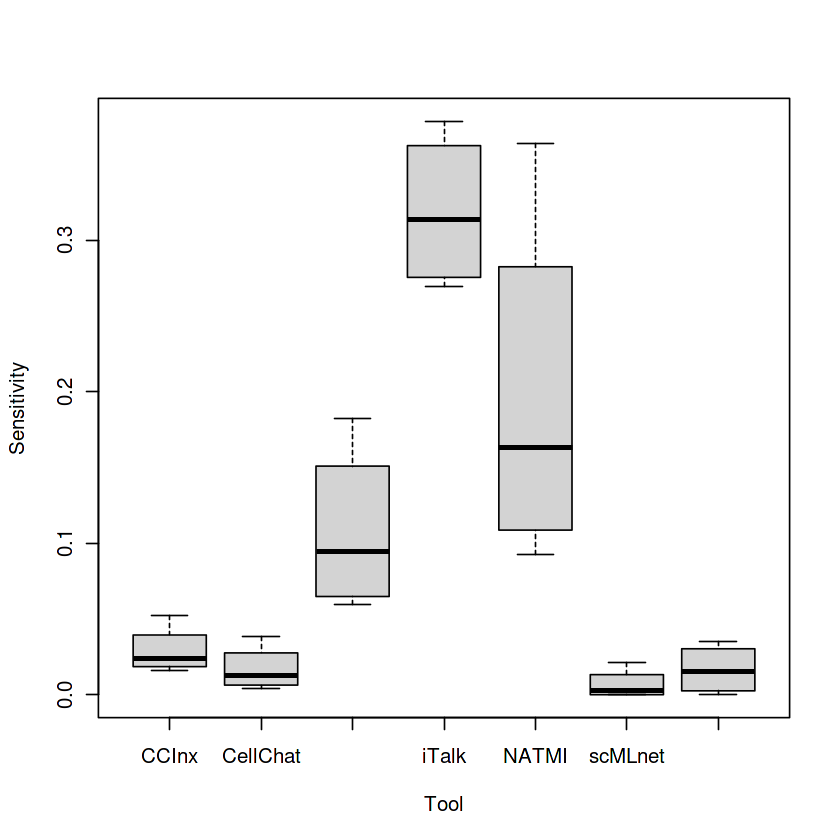

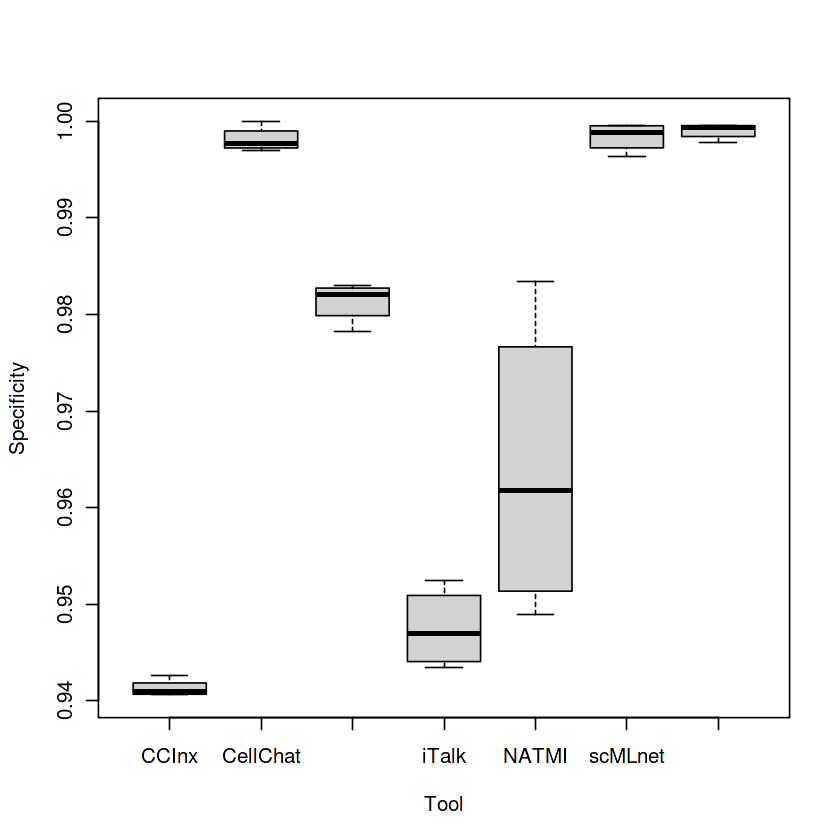

In [44]:
# Box plot of SSP
box <- cbind(CellChat_SSPA,CellChat_SSPB,CellChat_SSPC,CellChat_SSPD,
iTalk_SSPA,iTalk_SSPB,iTalk_SSPC,iTalk_SSPD,
SingleCellSignalR_SSPA,SingleCellSignalR_SSPB,SingleCellSignalR_SSPC,SingleCellSignalR_SSPD,
CCInx_SSPA,CCInx_SSPB,CCInx_SSPC,CCInx_SSPD,
scMLnet_SSPA,scMLnet_SSPB,scMLnet_SSPC,scMLnet_SSPD,
CellPhoneDB_SSPA,CellPhoneDB_SSPB,CellPhoneDB_SSPC,CellPhoneDB_SSPD,
NATMI_SSPA,NATMI_SSPB,NATMI_SSPC,NATMI_SSPD)

tool <- unlist(strsplit(colnames(box),split = "_"))[seq(1,ncol(box)*2,2)]

acc <- unlist(box[1,])
accbox <- data.frame(Tool=tool,Accuracy=acc)
plot1 <- boxplot(Accuracy~Tool, accbox)

sen <- unlist(box[2,])
senbox <- data.frame(Tool=tool,Sensitivity=sen)
plot2 <- boxplot(Sensitivity~Tool, senbox)

spe <- unlist(box[3,])
spebox <- data.frame(Tool=tool,Specificity=spe)
plot3 <- boxplot(Specificity~Tool, spebox)